In [384]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [359]:
import warnings
warnings.filterwarnings('ignore')

In [360]:
# Read the dataset
df = pd.read_csv('heart_failure_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [361]:
# look for null values
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [362]:
# check for data types
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

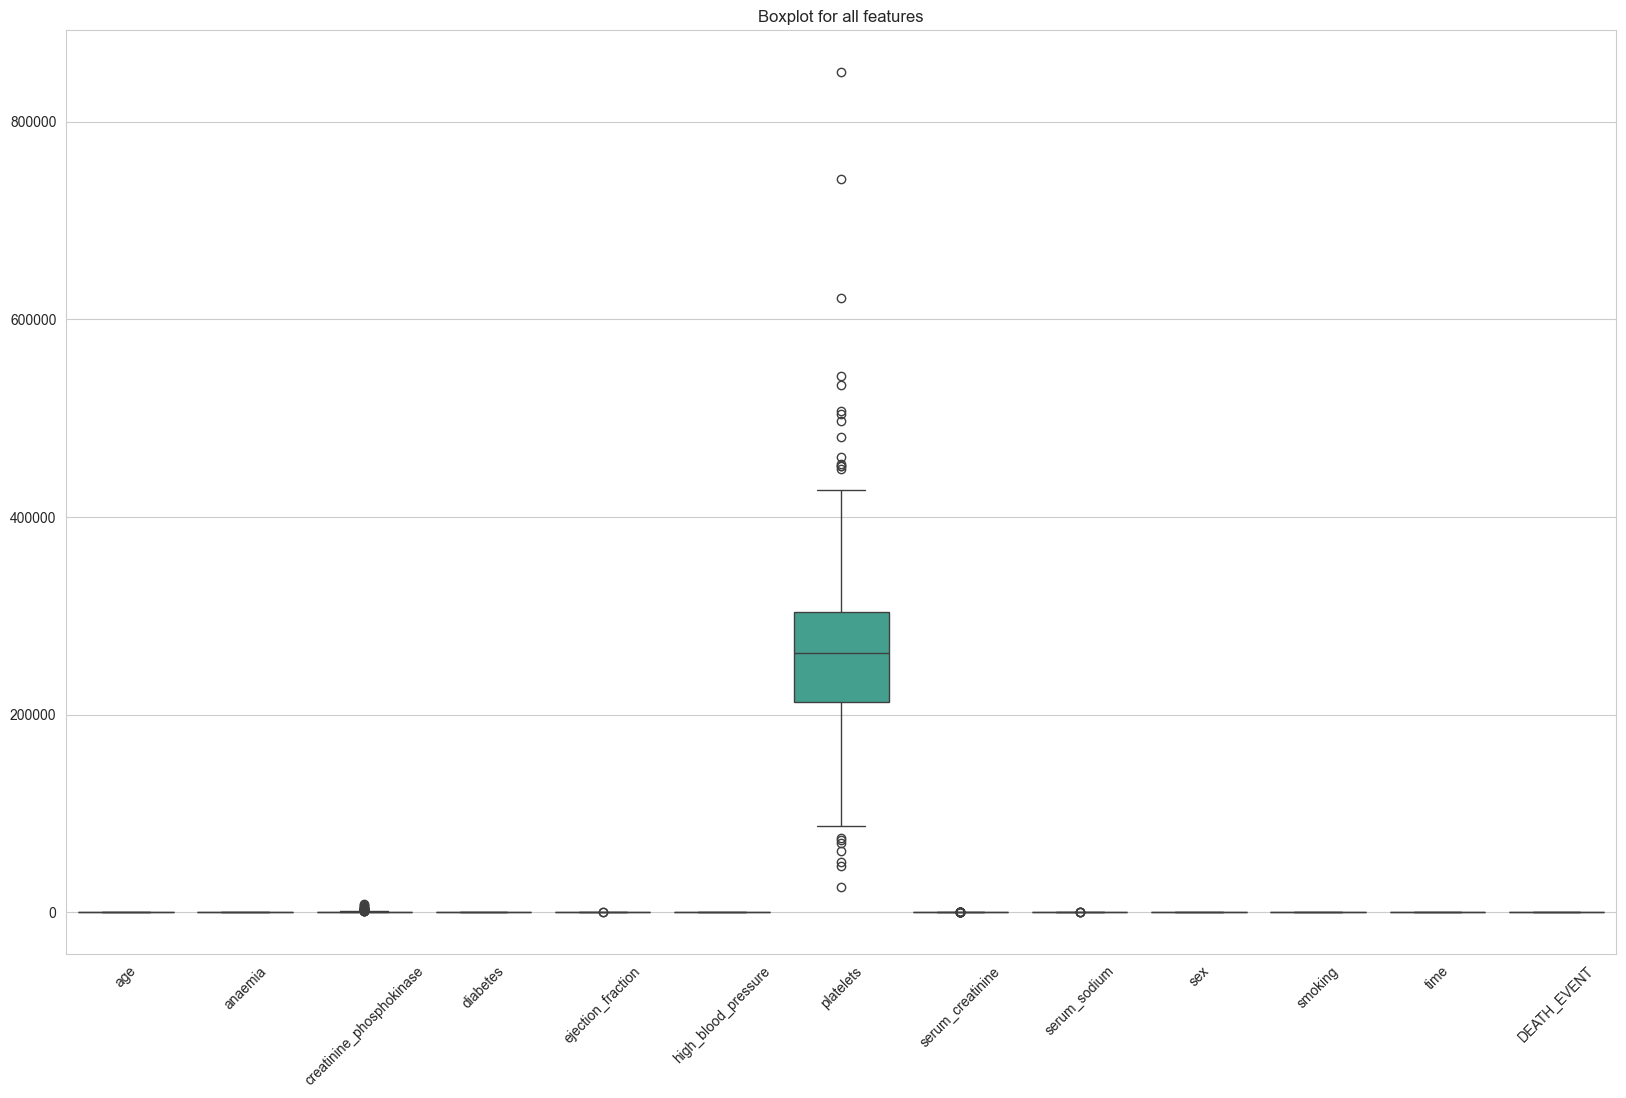

In [363]:
# check for outliers
sns.set_style("whitegrid")

# create box plots for all columns
plt.figure(figsize=(20, 12))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot for all features")
plt.show()

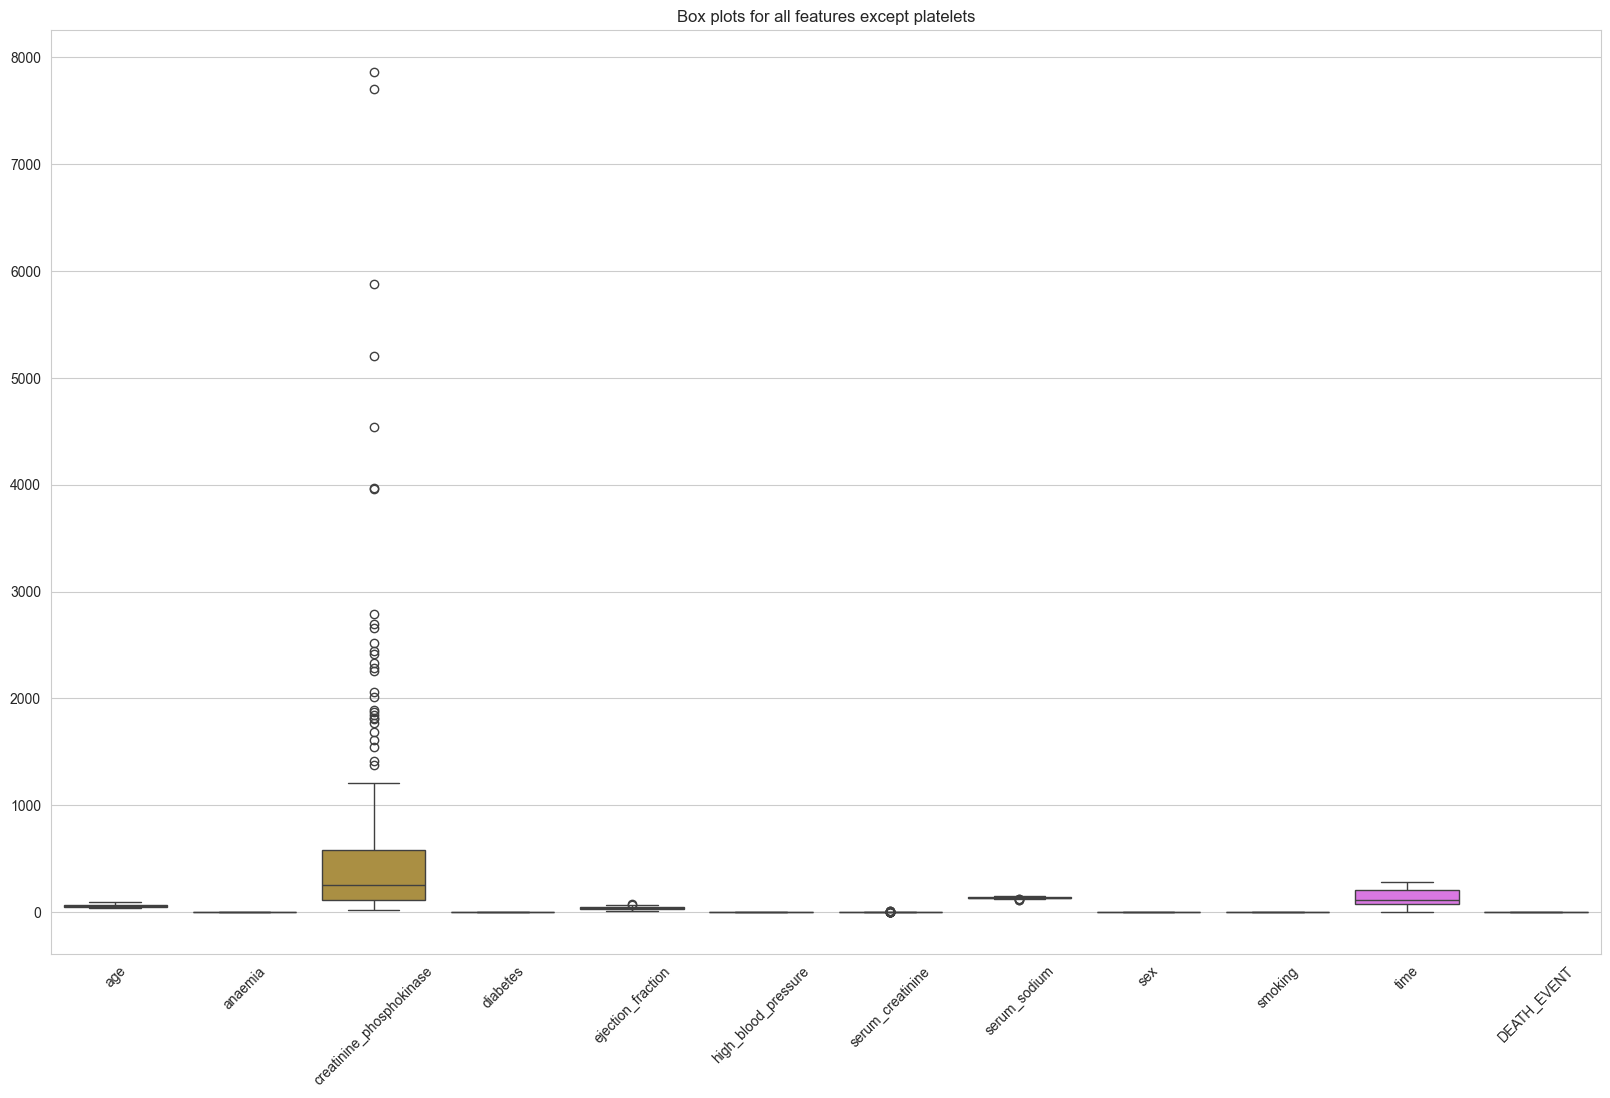

In [364]:
# remove platelets to examine other features
df_no_platelets = df.drop('platelets', axis=1)
# boxplot
plt.figure(figsize=(20, 12))
sns.boxplot(data=df_no_platelets)
plt.xticks(rotation=45)
plt.title("Box plots for all features except platelets")
plt.show()

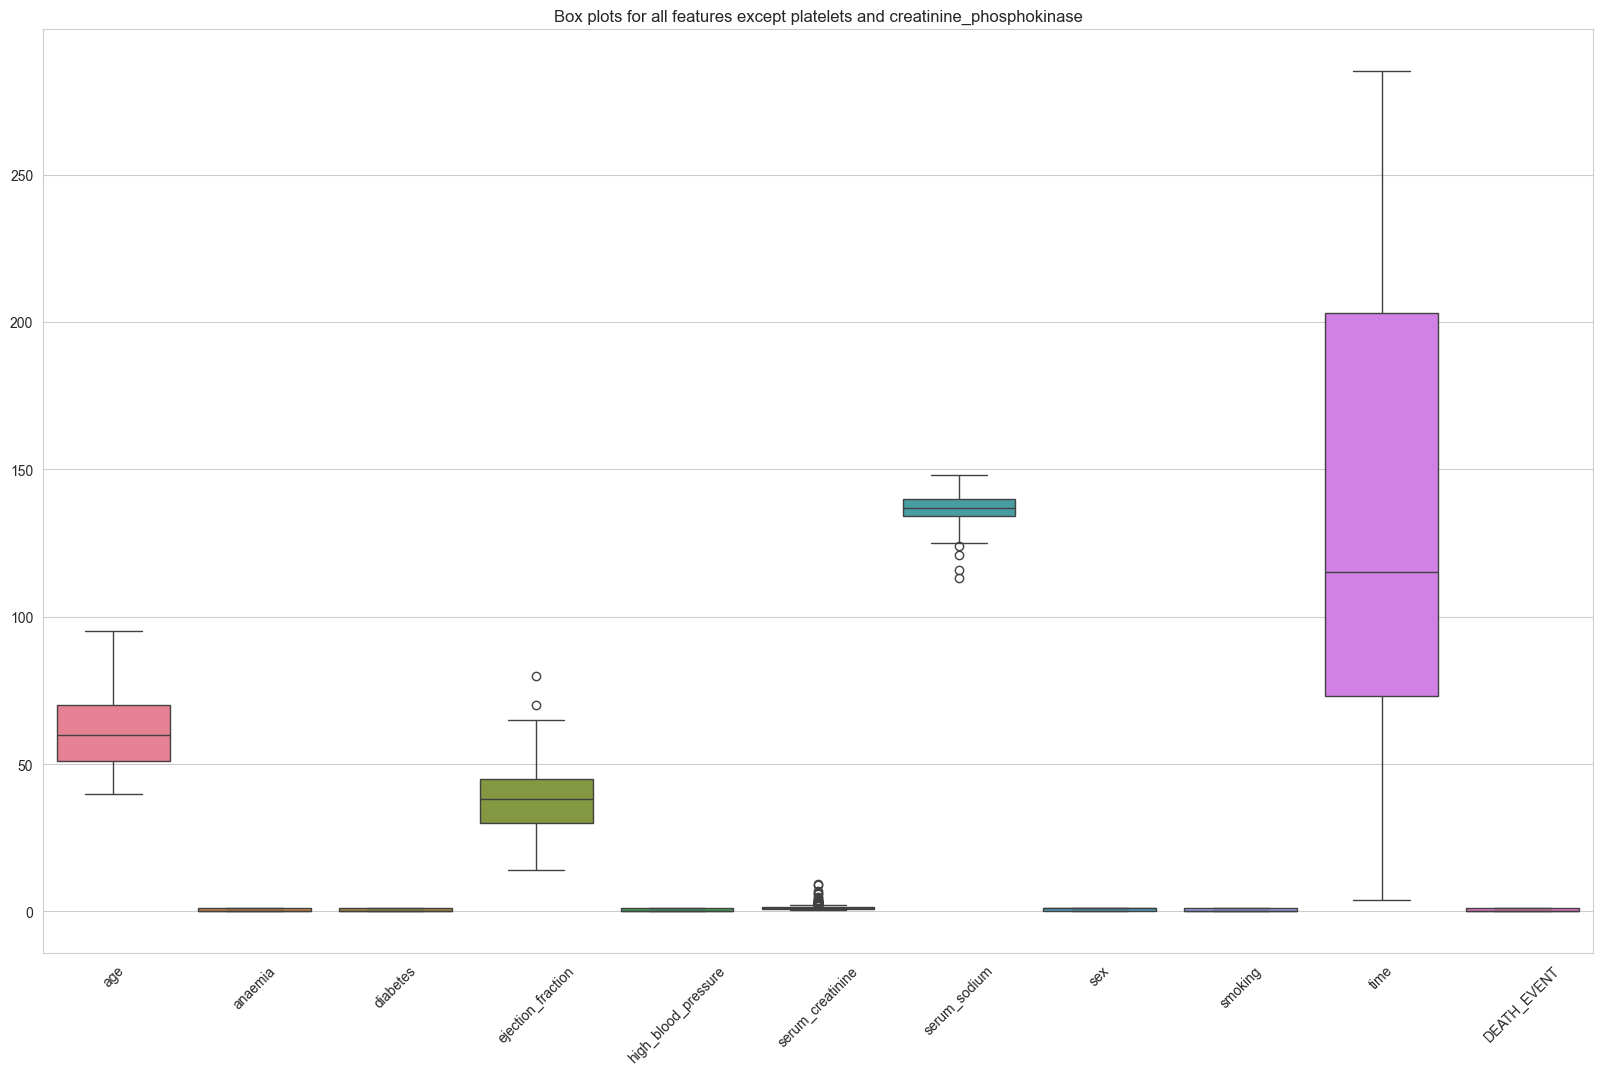

In [365]:
# remove platelets to examine other features
df_no_creat_plat = df_no_platelets.drop('creatinine_phosphokinase', axis=1)
# boxplot
plt.figure(figsize=(20, 12))
sns.boxplot(data=df_no_creat_plat)
plt.xticks(rotation=45)
plt.title("Box plots for all features except platelets and creatinine_phosphokinase")
plt.show()

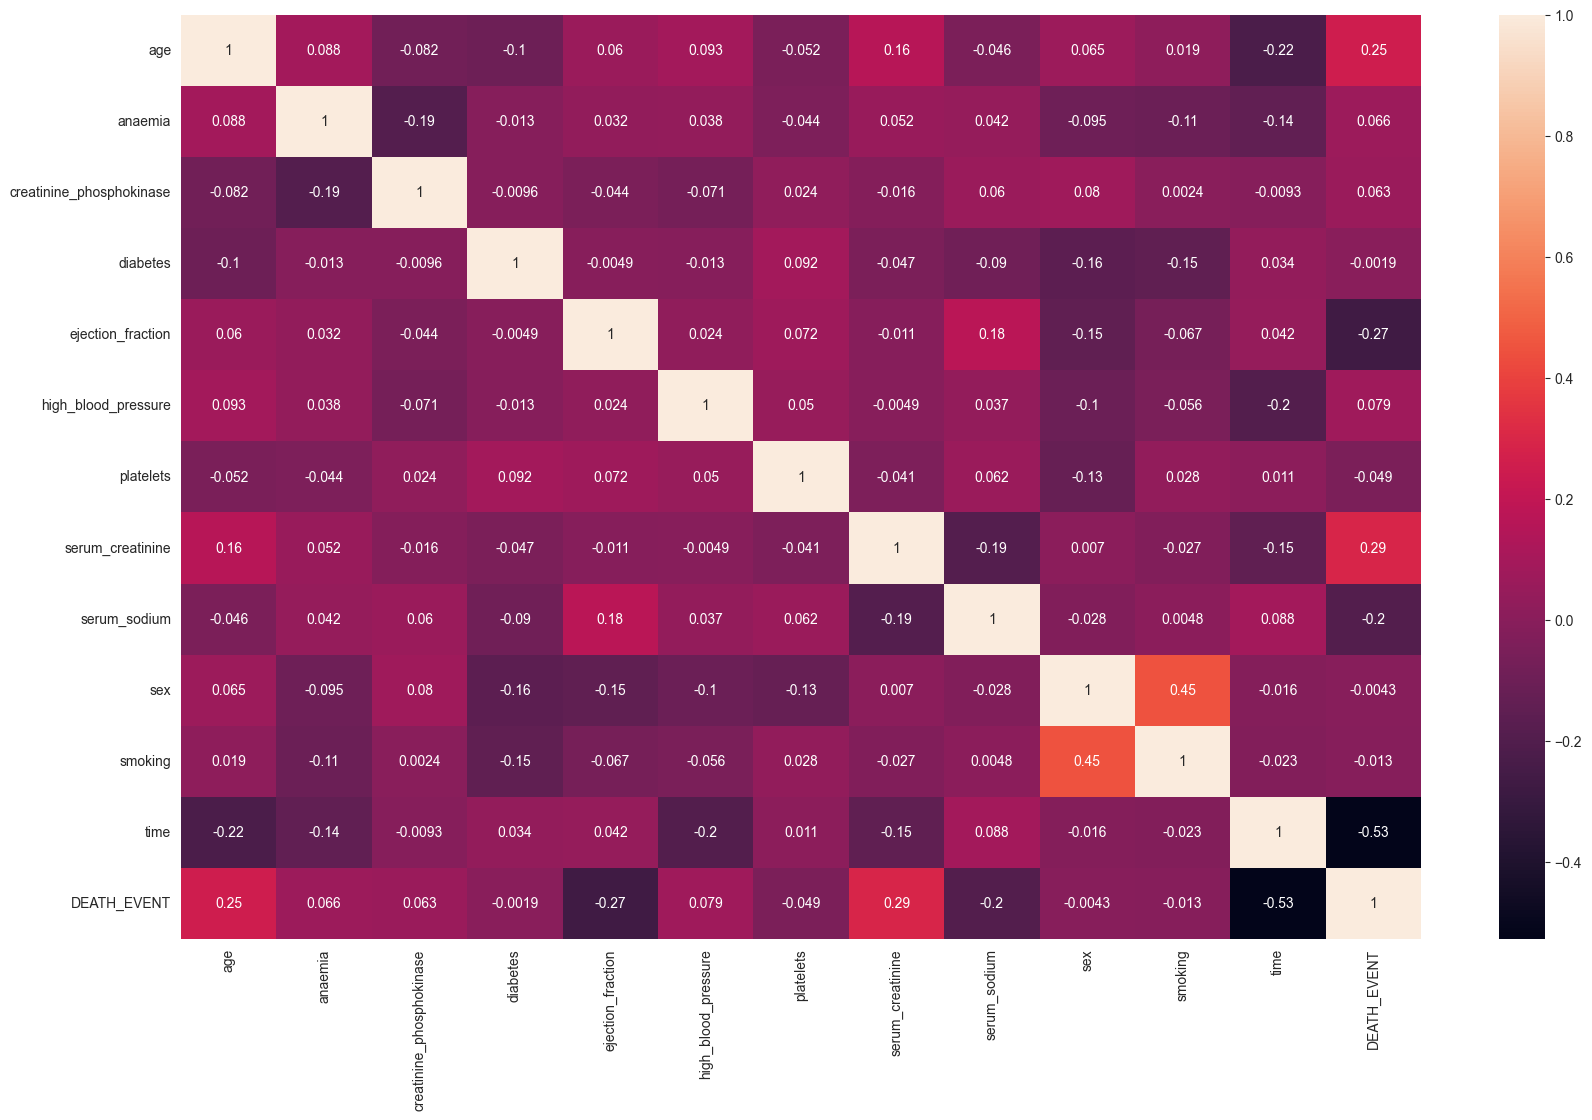

In [366]:
# heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [367]:
# remove outliers in creatinine_phosphokinase
Q1_cp = df['creatinine_phosphokinase'].quantile(0.25)
Q3_cp = df['creatinine_phosphokinase'].quantile(0.75)
IQR_cp = Q3_cp - Q1_cp
lower_bound_cp = Q1_cp - 1.5 * IQR_cp
upper_bound_cp = Q3_cp + 1.5 * IQR_cp

# remove outliers in platelets
Q1_pl = df['platelets'].quantile(0.25)
Q3_pl = df['platelets'].quantile(0.75)
IQR_pl = Q3_pl - Q1_pl
lower_bound_pl = Q1_pl - 1.5 * IQR_pl
upper_bound_pl = Q3_pl + 1.5 * IQR_pl

# remove outliers in serum_creatinine
Q1_sc = df['serum_creatinine'].quantile(0.25)
Q3_sc = df['serum_creatinine'].quantile(0.75)
IQR_sc = Q3_sc - Q1_sc
lower_bound_sc = Q1_sc - 1.5 * IQR_sc
upper_bound_sc = Q3_sc + 1.5 * IQR_sc

# remove outliers in serum_sodium
Q1_ss = df['serum_sodium'].quantile(0.25)
Q3_ss = df['serum_sodium'].quantile(0.75)
IQR_ss = Q3_ss - Q1_ss
lower_bound_ss = Q1_ss - 1.5 * IQR_ss
upper_bound_ss = Q3_ss + 1.5 * IQR_ss


# filter the data
filtered_df = df[(df['creatinine_phosphokinase'] >= lower_bound_cp) & 
                    (df['creatinine_phosphokinase'] <= upper_bound_cp) &  
                    (df['serum_creatinine'] >= lower_bound_sc) &
                    (df['serum_creatinine'] <= upper_bound_sc) & 
                    (df['serum_sodium'] >= lower_bound_ss) &
                    (df['serum_sodium'] <= upper_bound_ss) &
                    (df['platelets'] >= lower_bound_pl) & 
                    (df['platelets'] <= upper_bound_pl)]

# drop the diabetes and smoking columns
filtered_df = filtered_df.drop(['diabetes', 'smoking'], axis=1)

# display the shape of the original and filtered data
df.shape, filtered_df.shape

((299, 13), (225, 11))

In [368]:
# set variables for logistic regression
X = filtered_df.drop('DEATH_EVENT', axis=1)
y = filtered_df['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [369]:
# check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((180, 10), (45, 10), (180,), (45,))

In [370]:
# logistic regression
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

LogisticRegression()

In [371]:
LR_predict = LR_model.predict(X_test)

In [372]:
# prediction dataframe 
pd.DataFrame({'Actual': y_test, 'Predicted': LR_predict})

,Actual,Predicted
14,0,1
245,0,0
165,1,0
271,0,0
198,0,0
284,0,0
243,0,0
116,0,0
238,0,0
235,0,0


In [373]:
# check accuracy
LR_accuracy = accuracy_score(y_test, LR_predict)

# check confusion matrix
conf_mat = confusion_matrix(y_test, LR_predict)  

print(LR_accuracy)
print(conf_mat)

0.8444444444444444
[[33  3]
 [ 4  5]]


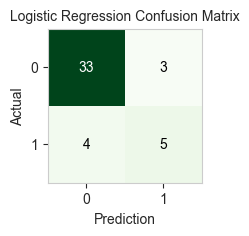

In [374]:
# plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat, figsize=(2,2), cmap=plt.cm.Greens)
plt.xlabel('Prediction', fontsize = 10)
plt.ylabel('Actual', fontsize = 10)
plt.title('Logistic Regression Confusion Matrix', fontsize = 10)
plt.show()

In [375]:
# naive bayes model
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

GaussianNB()

In [376]:
NB_predict = NB_model.predict(X_test)
NB_accuracy = accuracy_score(y_test, NB_predict)
#check accuracy
print(NB_accuracy)
print(confusion_matrix(y_test, NB_predict))

0.8888888888888888
[[35  1]
 [ 4  5]]


In [377]:
# prediction dataframe
pd.DataFrame({'Actual': y_test, 'Predicted': NB_predict})

,Actual,Predicted
14,0,1
245,0,0
165,1,0
271,0,0
198,0,0
284,0,0
243,0,0
116,0,0
238,0,0
235,0,0


In [378]:
# ensemble model hard voting
ensemble_model_hard = VotingClassifier(estimators=[('NB', NB_model), ('LR', LR_model)], voting='hard')

# ensemble model soft voting
ensemble_model_soft = VotingClassifier(estimators=[('NB', NB_model), ('LR', LR_model)], voting='soft')

ensemble_model_hard.fit(X_train, y_train)
ensemble_model_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('NB', GaussianNB()),
                             ('LR', LogisticRegression())],
                 voting='soft')

In [379]:
# Predictions
y_pred_hard = ensemble_model_hard.predict(X_test)
y_pred_soft = ensemble_model_soft.predict(X_test)

# Accuracy
accuracy_hard = accuracy_score(y_test, y_pred_hard)
accuracy_soft = accuracy_score(y_test, y_pred_soft)

print("Hard Voting Accuracy:", accuracy_hard)
print("Soft Voting Accuracy:", accuracy_soft)

Hard Voting Accuracy: 0.8888888888888888
Soft Voting Accuracy: 0.8666666666666667


In [385]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_scaled, y_train)
svm_model = SVC(kernel='rbf', gamma='scale')
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)

SVM Accuracy: 0.8222222222222222


In [380]:
# Define the ANN model
model = Sequential()

# Input layer
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))

# Hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callbacks = [early_stopping, model_checkpoint]

In [381]:
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=20, validation_split=0.2, callbacks=callbacks)

Epoch 1/250
8/8 [==============================] - 1s 17ms/step - loss: 0.6962 - accuracy: 0.5347 - val_loss: 0.6277 - val_accuracy: 0.8056
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.6357 - accuracy: 0.6875 - val_loss: 0.5612 - val_accuracy: 0.7500
Epoch 3/250
8/8 [==============================] - 0s 9ms/step - loss: 0.5844 - accuracy: 0.7083 - val_loss: 0.5147 - val_accuracy: 0.7500
Epoch 4/250
8/8 [==============================] - 0s 9ms/step - loss: 0.5447 - accuracy: 0.7361 - val_loss: 0.4711 - val_accuracy: 0.7778
Epoch 5/250
8/8 [==============================] - 0s 8ms/step - loss: 0.5144 - accuracy: 0.7222 - val_loss: 0.4242 - val_accuracy: 0.8056
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4773 - accuracy: 0.7639 - val_loss: 0.3826 - val_accuracy: 0.8056
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4331 - accuracy: 0.7778 - val_loss: 0.3500 - val_accuracy: 0.8333
Epoch 8/250
8/8 [=========

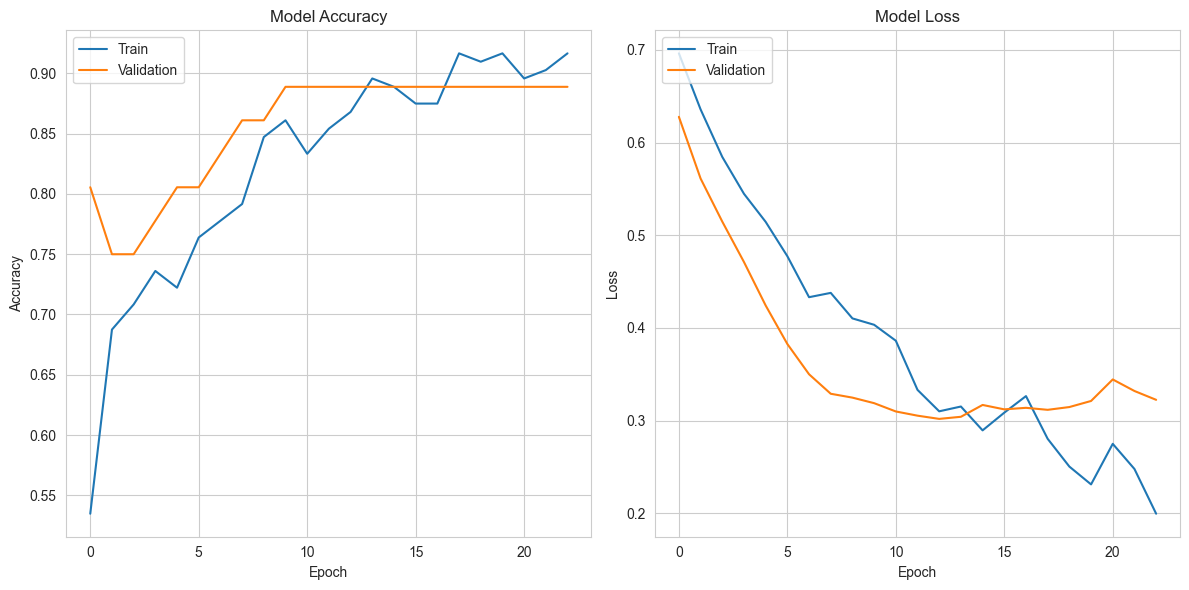

In [382]:
# plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()